In [ ]:
#here everyone pastes their individual working parts after working on them in their personal branch


<!--TABLE OF CONTENTS-->
Contents:
- [Introduction](#Introduction)
  - [What business problem are you solving?](#What-business-problem-are-you-solving?)
  - [What is the machine learning problem that you are solving?](#What-is-the-machine-learning-problem-that-you-are-solving?)
- [Data exploration and preparation](#Data-exploration-and-preparation)
- [Feature Engineering and ex ante Feature Selection](#Feature-Engineering-and-ex-ante-Feature-Selection)
- [Modeling](#Modeling)
  - [Linear Models](#Linear-Models)
    - [Ridge](#Ridge)
    - [Lasso](#Lasso)
  - [Tree Models](#Tree-Models)
    - [XGBoost](#XGBoost)
    - [CatBoost](#CatBoost)
    - [Random Forest](#Random-Forest)
  - [Classification Models](#Classification-Models)
    - [KNN](#KNN)
  - [Neural Network](#Neural-Network)
- [Model Evaluation](#Model-Evaluation)
- [Model Interpretation](#Model-Interpretation)

## Introduction
### Group number:
### Group members:
Timm Vordermark | Gabriel Sáenz Ruhsert
### Student IDs:
65983 | 64499
### Project name:

## What business problem are you solving?
- Please state clearly what business problem are you solving. (one sentence)
- Elaborate why is this a relevant problem, and what can you do with the model output to create business value, i.e., how is the model output actionable. (2-3 paragraphs)

## What is the machine learning problem that you are solving?
- Please state clearly what is the ML problem.
- If applicable state your target.

## Data exploration and preparation

- How many data instances do you have?
- Do you have duplicates?
- How many features? What type are they?
- If they are categorical, what categories they have, what is their frequency?
- If they are numerical, what is their distribution?
- Do you have outliers, and do you need to do anything about them?
- What is the distribution of the target variable?
- If you have a target, you can also check the relationship between the target and the variables.
- Do you have missing data? If yes, how are you going to handle it?
- Can you use the features in their original form, or do you need to alter them in some way?
- What have you learned about your data? Is there anything that can help you in feature engineering or modeling?


In the following section we perform comprehensive cleaning an preprocessing on the given financial dataset. First,  the Date column is standadized to datetime format and rows with missing date values are removed. We also drop rows that have missing values in both Brand_Name and Ticker, as these are essential identifiers. The code then standardizes text by converting Brand_Name to lowercase and Ticker to uppercase. We built dictionaries to impute missing Ticker or Brand_Name values based on the other, using the existing mappings from Ticker/Brand_Name. Sparse event columns like Dividends and Stock Splits are filled with 0, assuming no events. For Industry_Tag and Country, the most common value per brand is used to fill missing or inconsistent entries. Finally, columns like Open, High, and Low—which correlate closely with the target Close price—are dropped to avoid data leakage, along with Brand_Name (redundant with Ticker). The dataset is further cleaned by dropping rows with missing target (Close) and feature (Volume) values to ensure high-quality inputs for modeling.

# Begründung Volume

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.inspection import permutation_importance
import shap
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor, plot_tree
from scipy.stats import uniform as sp_uniform
from catboost import CatBoostRegressor
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('pr13_stocks (1).csv', index_col=0)

(100000, 12)
Date             object
Dividends       float64
Stock Splits    float64
Brand_Name       object
Ticker           object
Industry_Tag     object
Country          object
Volume          float64
Open            float64
High            float64
Low             float64
Close           float64
dtype: object
                        Date  Dividends  Stock Splits  \
0  2021-01-25 00:00:00-05:00        0.0           0.0   
1  2019-09-12 00:00:00-04:00        0.0           0.0   
2  2015-12-29 00:00:00-05:00        0.0           0.0   
3  2014-06-13 00:00:00-04:00        0.0           0.0   
4  2017-10-06 00:00:00-04:00        0.0           0.0   

                Brand_Name Ticker    Industry_Tag      Country      Volume  \
0                    crocs   CROX        footwear          usa   1102500.0   
1                   target    TGT          retail          usa   3185700.0   
2                 unilever     UL  consumer goods  netherlands   1278700.0   
3                      amd    

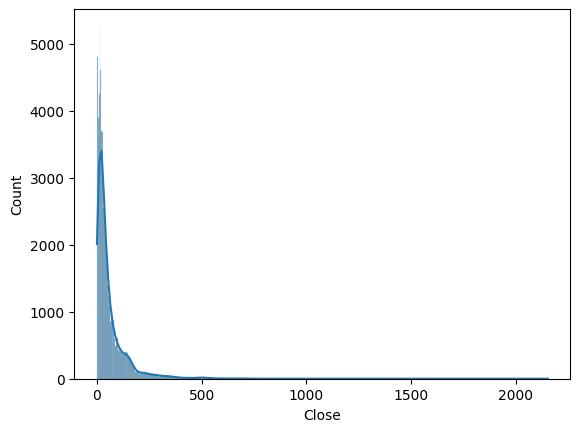

Number of duplicates: 0
Number of Missing Values: 4261
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          99984 non-null  object 
 1   Dividends     99941 non-null  float64
 2   Stock Splits  99542 non-null  float64
 3   Brand_Name    99775 non-null  object 
 4   Ticker        99825 non-null  object 
 5   Industry_Tag  99966 non-null  object 
 6   Country       99900 non-null  object 
 7   Volume        99148 non-null  float64
 8   Open          99197 non-null  float64
 9   High          99336 non-null  float64
 10  Low           99319 non-null  float64
 11  Close         99806 non-null  float64
dtypes: float64(7), object(5)
memory usage: 9.9+ MB


,Dividends,Stock Splits,Volume,Open,High,Low,Close
count,99941.000000,99542.000000,9.914800e+04,99197.000000,99336.000000,99319.000000,99806.000000
mean,0.003058,0.000536,2.347898e+07,65.486750,66.153202,64.724860,65.467484
std,0.044493,0.050264,8.820551e+07,118.103474,119.203651,116.686773,117.964329
min,0.000000,0.000000,0.000000e+00,0.199012,0.199922,0.196739,0.199164
25%,0.000000,0.000000,1.354575e+06,15.060389,15.268422,14.853267,15.043717
50%,0.000000,0.000000,4.621250e+06,32.457324,32.835369,32.076428,32.505058
75%,0.000000,0.000000,1.228455e+07,72.571576,73.143646,71.884888,72.491188
max,2.012000,10.000000,2.768427e+09,2152.699951,2173.629883,2119.989990,2153.199951


In [5]:
#General Information about the Dataset
print(df.shape)
print(df.dtypes)
print(df.head())
sns.histplot(data=df, x='Close', bins='auto', kde=True)
plt.show()
print('Number of duplicates:', np.sum(df.duplicated()))
print('Number of Missing Values:', df.isnull().sum().sum())
#General Descriptives about the Dataset
df.info()
df.describe()

In [6]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)
#drop the 16 rows without any date data
df = df.dropna(subset=['Date'])
#drop the row without both Brand_name and Ticker as we cannot say which company this entry refers to
df = df[~(df['Brand_Name'].isna() & df['Ticker'].isna())].copy()

df['Brand_Name'] = df['Brand_Name'].str.lower()
df['Ticker'] = df['Ticker'].str.upper()

brand_to_ticker = df.dropna(subset=['Brand_Name', 'Ticker'])\
                        .drop_duplicates(subset=['Brand_Name'])\
                        .set_index('Brand_Name')['Ticker'].to_dict()

ticker_to_brand = df.dropna(subset=['Brand_Name', 'Ticker'])\
                        .drop_duplicates(subset=['Ticker'])\
                        .set_index('Ticker')['Brand_Name'].to_dict()

    # Fill missing Ticker using Brand_Name
df.loc[df['Ticker'].isna() & df['Brand_Name'].notna(), 'Ticker'] = (
        df.loc[df['Ticker'].isna() & df['Brand_Name'].notna(), 'Brand_Name']
        .map(brand_to_ticker)
    )

    # Fill missing Brand_Name using Ticker
df.loc[df['Brand_Name'].isna() & df['Ticker'].notna(), 'Brand_Name'] = (
    df.loc[df['Brand_Name'].isna() & df['Ticker'].notna(), 'Ticker']
    .map(ticker_to_brand))



#As dividend payments and stock splits are sparse, event-based features, missing values here are likely because
#no such event has occured. Therefore, missing values are filled with 0. Also, the occurence of missing values
#is relatively low here(59 and 458, respectively) compared to the overall dataset size(~100,000)
df['Dividends'] = df['Dividends'].fillna(0.0)
df['Stock Splits'] = df['Stock Splits'].fillna(0.0)




#Imputing industry tag values with the most frequent value for each brand

df['Industry_Tag'] = df['Industry_Tag'].str.strip().str.lower()
industry_map = (
        df.dropna(subset=['Industry_Tag'])
          .groupby('Brand_Name')['Industry_Tag']
          .agg(lambda x: x.mode()[0])
          .to_dict()
    )

df['Industry_Tag'] = df.apply(
        lambda row: industry_map[row['Brand_Name']]
        if pd.isna(row['Industry_Tag']) or row['Industry_Tag'] != industry_map.get(row['Brand_Name'])
        else row['Industry_Tag'],
        axis=1
    )

#same for country

df['Country'] = df['Country'].str.strip()

country_map = (
        df.dropna(subset=['Country'])
          .groupby('Brand_Name')['Country']
          .agg(lambda x: x.mode()[0])
          .to_dict()
    )

df['Country'] = df.apply(
        lambda row: country_map[row['Brand_Name']]
        if pd.isna(row['Country']) or row['Country'] != country_map.get(row['Brand_Name'])
        else row['Country'],
        axis=1
    )

#drop Open High Low since they give information at the same day as they are not independent of the Close price --> our target
# drop Brand Name as it contains the same info as Ticker
df = df.drop(columns=['Open', 'High', 'Low','Brand_Name'])
#drop all nans in target and the corresponding rows -->hard to predict without target
print(df.shape,'shape before Close dropped')
df = df.dropna(subset=['Close']) #194 rows dropped
print(df.shape,'shape before vol dropped')
#drop all nans in volumne and the corresponding rows
df = df.dropna(subset=['Volume']) #852 rows dropped
print(df.shape,'shape after vol dropped')


#we decided not to exclude outliers, however they are defined, since we expect the models to learn from these 'special' circumstances.


(99983, 8) shape before Close dropped
(99789, 8) shape before vol dropped
(98937, 8) shape after vol dropped


# Outliers Dropped?

In [7]:
duplicated = df[df.duplicated(subset=['Ticker', 'Date'], keep=False)]
duplicated
#drop all duplicates if the ticker and Date are the same
df = df.drop_duplicates(subset=['Ticker', 'Date'], keep='first')

In [8]:
#check
print(df.isna().sum())
df

Date            0
Dividends       0
Stock Splits    0
Ticker          0
Industry_Tag    0
Country         0
Volume          0
Close           0
dtype: int64


,Date,Dividends,Stock Splits,Ticker,Industry_Tag,Country,Volume,Close
0,2021-01-25 05:00:00+00:00,0.0,0.0,CROX,footwear,usa,1102500.0,73.910004
1,2019-09-12 04:00:00+00:00,0.0,0.0,TGT,retail,usa,3185700.0,100.359192
2,2015-12-29 05:00:00+00:00,0.0,0.0,UL,consumer goods,netherlands,1278700.0,33.908924
3,2014-06-13 04:00:00+00:00,0.0,0.0,AMD,technology,usa,17734600.0,4.280000
4,2017-10-06 04:00:00+00:00,0.0,0.0,DIS,entertainment,usa,4360200.0,96.541939
...,...,...,...,...,...,...,...,...
99995,2004-06-18 04:00:00+00:00,0.0,0.0,FDX,logistics,usa,957800.0,66.604805
99996,2022-06-24 04:00:00+00:00,0.0,0.0,HSY,food & beverage,usa,1154300.0,215.966888
99997,2017-09-06 04:00:00+00:00,0.0,0.0,UL,consumer goods,netherlands,1079900.0,47.880238
99998,2021-06-04 04:00:00+00:00,0.0,0.0,AMZN,e-commerce,usa,44994000.0,160.311005


## Feature Engineering and ex ante Feature Selection
Creating good features is probably the most important step in the machine learning process.
This might involve doing:
- transformations
- aggregating over data points or over time and space, or finding differences (for example: differences between two monthly bills, time difference between two contacts with the client)
- creating dummy (binary) variables
- discretization

Business insight is very relevant in this process. If it is possible you can also find additional relevant data.

As decribed above the idea behind feature engineering is to create new features that carry more predictive power and help the model to increase its performance.We start by extracting time-related features from the Date column, such as the year, month, day of year, and day of the week, under the assumption that stock performance may follow time patterns. Day_Number is also computed to represent time progression numerically.

In [9]:
#include new time features, since we expected to find some pattern of the time, e.g. an increase over the years (that we see), or an increase on certain days of the week or the year (cannot observe that).
df['Date'] = pd.to_datetime(df['Date'])

# Time-based features
df['Year'] = df['Date'].dt.year.astype('int32')
df['Month'] = df['Date'].dt.month.astype('int32')
df['Day'] = df['Date'].dt.dayofyear.astype('int32')
df['DayOfWeek'] = df['Date'].dt.dayofweek.astype('int32')  # 0 = Monday, 6 = Sunday

# Running day number to determine the date on, rather than a datetime type
df['Day_Number'] = (df['Date'] - df['Date'].min()).dt.days
df = df.sort_values(by='Date').reset_index(drop=True)

The dataframe is enriched with lagged features using the add_lags function, which creating shifted versions of the Close price and Volume, as well as the number of days between the current and lagged observations. The idea is that the model can identify short-term historical trends.

In [10]:
#we wanted to add the past close prices, volumnes and the time distance to the current date in days to the df
def add_lags(df, lags):
    for lag in lags:
        df[f'Close_Lag_{lag}' ] = df.groupby('Ticker' )['Close'].shift(lag)
        df[f'Volume_Lag_{lag}' ] = df.groupby('Ticker')['Volume'].shift(lag)
        df[f'Days_Since_Lag_{lag}' ] = df.groupby('Ticker')['Date'].diff(lag).dt.days
    return df


To include time and price sensitive features we wanted to include a time weighted average and std. This ensures that more recent prices carry more weight, reflecting their likely higher relevance to current market behavior. At the same time simple unweighted rolling mean and std are computed for comparison using the add_simple_mean_std function, which helps to evaluate the effect of time-weighting on predictive features.

In [11]:
#we wanted to implement a time weighted mean and std to the df. because our initial function took over 30min we improved speed with numba
from numba import njit

#calculate the weighted mean and std using numba (dramatic time reduction)
@njit
def weighted_mean_std_numba(close_lags, days_diff):

    if np.sum(days_diff) == 0:
        return np.nan, np.nan

    weight = 1.0/days_diff
    weight_sum = np.sum(weight)


    if weight_sum == 0.0 or np.any(np.isnan(weight)) or np.any(np.isinf(weight)):
        return np.nan, np.nan



    weighted_mean = np.sum(weight* close_lags) /weight_sum
    weighted_var = np.sum(weight*(close_lags- weighted_mean)**2) /weight_sum
    weighted_std = np.sqrt(weighted_var)

    return weighted_mean, weighted_std

def add_weighted_mean_std_numba(df, lookback_periods):
    df = df.sort_values(['Ticker', 'Date']).copy()

    for lookback in lookback_periods:
        weighted_means = np.full(len(df),np.nan)
        weighted_stds = np.full(len(df), np.nan)

        idx = df.index.to_numpy()
        closes = df['Close'].to_numpy()
        dates = pd.to_datetime(df['Date']).values.astype('datetime64[D]')
        tickers = df['Ticker'].to_numpy()

        unique_tickers = np.unique(tickers)

        for ticker in unique_tickers:

            ticker_mask = tickers == ticker
            ticker_indices = np.where(ticker_mask)[0]

            for i in range(lookback, len(ticker_indices)):

                idx_range = ticker_indices[i - lookback:i]
                current_idx = ticker_indices[i]


                close_lags = closes[idx_range]

                date_lags = dates[idx_range]
                current_date = dates[current_idx]
                days_diff = (current_date - date_lags).astype(np.int64)



                if np.any(days_diff == 0) or np.any(np.isnan(close_lags)):
                    continue

                mean_val, std_val = weighted_mean_std_numba(close_lags , days_diff)
                weighted_means[current_idx] =mean_val
                weighted_stds[current_idx] = std_val

        df[f'Weighted_Mean_{lookback}']= weighted_means
        df[f'Weighted_Std_{lookback}']= weighted_stds

    return df


In [12]:
#we also wanted to see how simply shifting the lookback period would influence the feature, without taking the timing differnce into account.
def add_simple_mean_std(df, lookback_periods):
    df = df.sort_values(['Ticker', 'Date']).copy()

    for lookback in lookback_periods:

        means =[]
        stds =[]
        for ticker, group in df.groupby('Ticker'):

            group = group.sort_values('Date')
            closes = group['Close_Lag_1'].reset_index(drop=True)
            mean_vals = closes.rolling(window=lookback,min_periods=lookback).mean()
            std_vals = closes.rolling(window=lookback, min_periods=lookback).std()

            means.append(pd.Series(mean_vals.values, index=group.index))
            stds.append(pd.Series(std_vals.values, index=group.index))


        df[f'Simple_Mean_{lookback}'] =pd.concat(means)
        df[f'Simple_Std_{lookback}'] =pd.concat(stds)

    return df

Additional engineered features include daily returns and differences in Close prices, giving us insight into market momentum from the last close price.

In [13]:
#we added the return of the previous day
def add_returns(df):
    df['return_since_last_entry'] = df['Close_Lag_1']/df['Close_Lag_2'] -1

    return df

In [14]:
#we added the Close price difference of the previous day
def add_diff(df):
    df['diff_since_last_entry'] = df['Close_Lag_1']-df['Close_Lag_2']

    return df

Binary signal features are also introduced to indicate the presence of dividends and stock splits, rather then just their numerical value. The idea was to help the model detect event-driven price changes, just on the events not on their actual value.

In [15]:
#since so many rows for dividends and stock splits are zero we wanted to add a signal for it to the df
def add_cat_signals(df, cols):
    for col in cols:
        new_col = f"{col}_signal"
        df[new_col] = (df[col] != 0).astype('int32')
    return df

In [16]:
df = add_lags(df, [1,2,3,4,5,10,20,30,40,50,60,70,80,90,100])

In [17]:
df = add_weighted_mean_std_numba(df,[2,3,4,5,10,20,30,40,50,60,70,80,90,100])


In [18]:
df = add_simple_mean_std(df,[2,3,4,5,10,20,30,40,50,60,70,80,90,100])


In [19]:
df = add_returns(df)


In [20]:
df = add_diff(df)


In [21]:
df = add_cat_signals(df, ['Dividends','Stock Splits'])

In [22]:
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print(df.columns)
df.isna().sum()

Index(['Date', 'Dividends', 'Stock Splits', 'Ticker', 'Industry_Tag',
       'Country', 'Volume', 'Close', 'Year', 'Month',
       ...
       'Simple_Mean_80', 'Simple_Std_80', 'Simple_Mean_90', 'Simple_Std_90',
       'Simple_Mean_100', 'Simple_Std_100', 'return_since_last_entry',
       'diff_since_last_entry', 'Dividends_signal', 'Stock Splits_signal'],
      dtype='object', length=118)


Date                          0
Dividends                     0
Stock Splits                  0
Ticker                        0
Industry_Tag                  0
                           ... 
Simple_Std_100             6100
return_since_last_entry     122
diff_since_last_entry       122
Dividends_signal              0
Stock Splits_signal           0
Length: 118, dtype: int64

We delete the Date column since we have the same information in the Day_number column. Moreover we cannot include the volumne column since this value also captures information that is not avialable before market closing.

In [23]:
#since date is in the datetime type and the information of time is preserved in the Day_number column we can delete it
df = df.drop('Date', axis=1)
#we need to delete Volumne since it contains information to some extend about the same day. therefore we cannot use it. remeber we still have a lagged volumne in the df
df = df.drop('Volume', axis=1)
# print(df['Stock Splits_signal'].sum())

In [24]:
# df.to_csv('pr13_all_cols.csv', index=False)

# oder hier nicht samplen sondern das letzte Jahr nehmen?

In [ ]:
#to visualize dependecies between features and grasp their behavior we make the assumption that ~10k rows = 10% of the dataset is sufficient
# df_fs = df.sample(frac=0.1, random_state=42)
df_fs = df[df['Day_Number']>=8036] # we assume that the last time period is more important rather then randomly sampling
print(df[df['Day_Number']==8036]) #first day in 2022 --> 9273 rows ~10%

       Dividends  Stock Splits Ticker    Industry_Tag      Country  \
89666        0.0           0.0   ABNB     hospitality          usa   
89679        0.0           0.0   ADBE      technology          usa   
89670        0.0           0.0  ADDYY         apparel      germany   
89683        0.0           0.0    AEO         apparel          usa   
89667        0.0           0.0  BAMXF      automotive      germany   
...          ...           ...    ...             ...          ...   
89675        0.0           0.0   NVDA      technology          usa   
89681        0.0           0.0     PG  consumer goods          usa   
89668        0.0           0.0    PHG      technology  netherlands   
89672        0.0           0.0  UBSFY          gaming       france   
89680        0.0           0.0      V         finance          usa   

            Close  Year  Month  Day  DayOfWeek  ...  Simple_Mean_80  \
89666  172.679993  2022      1    3          0  ...      165.808500   
89679  564.369995

In [ ]:
filtered_df = df_fs[df_fs['Close'] > 1800]
filtered_df

df_fs = df_fs[df_fs['Ticker'] != 'CMG']

# Outlier CMG ???

These scatterplots visualize Close vs. Year, Month, Day, and DayOfWeek, to explore how Close behaves over time and identify time-related patterns in stock prices. We observe higher Close prices for an increase in year. Moreover we see that several tickers show gernerally higher Close prices.

In [ ]:
#Here we wanted to visualize the behavior of time feature against the target column Close. E.g. find certain days where Close prices are higher then normal

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_fs, x="Close", y="Year",hue="Ticker", legend=False)
plt.title('Close vs Year')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_fs, x="Close", y="Year",hue="Ticker", legend=False)
plt.xlim(0,400)
plt.title('Close vs Year (Zoomed)')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_fs, x="Close", y="Month", hue="Ticker", legend=False)
plt.title('Close vs Month')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_fs, x="Close", y="Day", hue="Ticker", legend=False)
plt.title('Close vs Day')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_fs, x="Close", y="DayOfWeek", hue="Ticker", legend=False)
plt.title('Close vs DayOfWeek')
plt.show()

We plot relationships between numerical features (Close, Dividends, Stock Splits, and their binary signal columns) to see how these variables interact. Since we only have 17 stocksplit in the entire dataset and we sampled 10% we have 0 stocksplits in our subset. For dividends we see higher dividends for higher stock prices. The rest of the features does not really provides more insights.

In [ ]:
# 'pairplot of close, div, stock split, theri signal' remember there is only 17 stocksplits and around 900 dividends
g= sns.pairplot(df_fs[['Close', 'Dividends', 'Stock Splits', 'Dividends_signal', 'Stock Splits_signal','Ticker']], hue = 'Ticker', diag_kind="kde", corner=True)
g._legend.remove()
plt.show()

We now explore how categorical features (Country, Industry, and Ticker) relate to Close and want to observe their distribution. We see higher Close prices for usa, certain tickers (ADBE,NFLX etc.) and industries like technology and entertainment.

In [ ]:
#in the following we visualize the categorical columns Ticker , Country and Industry against the Close price
plt.figure(figsize=(10, 6))
sns.stripplot(x='Country', y='Close', data=df_fs, jitter=True, palette='deep')
plt.title('Country vs Close')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.stripplot(x='Industry_Tag', y='Close', data=df_fs, jitter=True, palette='muted')
plt.title('Industry vs Close')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.stripplot(x='Ticker', y='Close', data=df_fs, jitter=True, palette='bright')
plt.title('Ticker vs Close')
plt.xticks(rotation=90)
plt.show()


Are their any interactions between the categroical features? We basically observe the same trends we saw above.

In [ ]:
#Since the pairplot only support numerical varibles we decided to encode our categorical columns in a ordinal way, to be able to plot a pairplot
# Encode categorical features
plt.figure(figsize=(35, 35))
encoder = OrdinalEncoder()
encoded_features = encoder.fit_transform(df_fs[['Ticker', 'Industry_Tag','Country']])
encoded_df = pd.DataFrame(encoded_features , columns=['Ticker','Industry_Tag', 'Country'])
encoded_df['Close'] = df_fs['Close' ].values
g = sns.pairplot(encoded_df, diag_kind="kde", corner=True)

#from ordinal label axis back to names--> due to the number of ticker/industies --> not all names displayable
original_labels = df_fs[['Ticker', 'Industry_Tag','Country']]
for i, col in enumerate(['Ticker', 'Industry_Tag','Country']):
    mapping = dict(zip(
        encoded_df[col].unique(),
        original_labels[col].astype(str).unique()))
    for ax in g.axes.flat:
        if ax is not None:
            # Xlabels
            if ax.get_xlabel() == col:
                ticks = ax.get_xticks()
                labels = [mapping.get(tick, '') for tick in ticks]
                ax.set_xticklabels(labels, rotation=45)
            #ylabels
            if ax.get_ylabel() == col:
                ticks = ax.get_yticks()
                labels = [mapping.get(tick, '') for tick in ticks]
                ax.set_yticklabels(labels, rotation=0)
plt.tight_layout()
plt.show()

We also wanted to visualize the dependece of Close by return (relative change) and price difference (absolute change) from the last day. We find that returns are normally/t-student distributed, as expected (with some outlying tickers), while the price difference since the last entry is also centered around 0 with some tickers coloring the outer parts of the distribution.

In [ ]:
g = sns.pairplot(df_fs[['return_since_last_entry','diff_since_last_entry','Close', 'Ticker']], hue = "Ticker", diag_kind="kde", corner=True)
g._legend.remove()
plt.show()

As we expect that the most recent features have the most impact on the Close price we plotted them individually and observed a strong linear relationship between the last Close price and our target. Volume and the number of days since the last entry do not seem to give much information.

In [ ]:
g = sns.pairplot(df_fs[['Close_Lag_1','Volume_Lag_1','Days_Since_Lag_1','Close', 'Ticker']], hue = "Ticker", diag_kind="kde", corner=True)
g._legend.remove()
plt.show()

Moreover we wanted to see the influence of the weighting in comparison to the simple mean and std for different lookback periods. For reasons of simplicity and clarity we are only showing the lookback period = 2. What we can observe in these pairplots, that the weigthing seems to increase the linearity of the model, since the distribution of mean and std seems to be less spread if the prices are time weighted. Again Volume and the number of days since the last entry seem not to provide much insights.

In [ ]:
lookback_list = [2]#,3,4,5,10,20,30,40,50,60,70,80,90,100] # we looked at all added features but for structure we just show lag 2 here. uncomment the remaining lags to see all
for lookback in lookback_list:
    print('Status: Lag', lookback)
    feature_list = f'Simple_Mean_{lookback}'
    g = sns.pairplot(df_fs[[f'Close_Lag_{lookback}',f'Volume_Lag_{lookback}',f'Days_Since_Lag_{lookback}',f'Simple_Mean_{lookback}',f'Simple_Std_{lookback}',f'Weighted_Mean_{lookback}',f'Weighted_Std_{lookback}','Close', 'Ticker']], hue = "Ticker", diag_kind="kde", corner=True)
    g._legend.remove()
    plt.show()

# what we see is that the weighted average shows cleaner linear distribution to the Close price, also the std is less spread --> prefer weighted over simple
# we observe that Days Since and volumne seem not to carry much information. Still left the last Volume Day Since to check later with correlation and mututual information

As a result we dropped all simple mean and std column since they would just include more noise than the weighted mean and std for the same lookback period. For Volumne and number of days since the last entry we decided to keep the last entry since this might be the most important out of all the volumne and number of days since the last entry to check their importance later.

In [ ]:
df_fs =df_fs.drop(columns=[col for  col in df_fs.columns if 'Simple' in col]) #all simple dropped
days_cols = [col  for col in df_fs.columns if 'Days_Since' in col]
df_fs = df_fs.drop(columns=days_cols[1:] ) # all but the first day since dropped
volume_cols = [col for col in df_fs.columns if 'Volume_Lag' in col]
df_fs =df_fs.drop( columns=volume_cols[1:]) # all but the first volumne dropped

In [ ]:
#determine categorical and numerical columns here

column_types = pd.DataFrame({
    'Column Name': df_fs.columns,
    'Data Type': df_fs.dtypes.values
})
print(column_types)

numerical_cols = df_fs.select_dtypes(include='float64').columns.tolist()
numerical_cols.append('Day_Number')

all_columns = df_fs.columns.tolist()

categorical_cols = list(set(all_columns) - set(numerical_cols))

print(categorical_cols)
print(numerical_cols)


                 Column Name Data Type
0                  Dividends   float64
1               Stock Splits   float64
2                     Ticker    object
3               Industry_Tag    object
4                    Country    object
..                       ...       ...
111           Simple_Std_100   float64
112  return_since_last_entry   float64
113    diff_since_last_entry   float64
114         Dividends_signal     int32
115      Stock Splits_signal     int32

[116 rows x 2 columns]
['Stock Splits_signal', 'DayOfWeek', 'Dividends_signal', 'Ticker', 'Year', 'Month', 'Day', 'Country', 'Industry_Tag']
['Dividends', 'Stock Splits', 'Close', 'Close_Lag_1', 'Volume_Lag_1', 'Days_Since_Lag_1', 'Close_Lag_2', 'Volume_Lag_2', 'Days_Since_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'Days_Since_Lag_3', 'Close_Lag_4', 'Volume_Lag_4', 'Days_Since_Lag_4', 'Close_Lag_5', 'Volume_Lag_5', 'Days_Since_Lag_5', 'Close_Lag_10', 'Volume_Lag_10', 'Days_Since_Lag_10', 'Close_Lag_20', 'Volume_Lag_20', 'Days_Sin

As discussed in the office hour, we tried to find the best features by looking at their importance before modeling, not assuming a tree or any other underlying model. Overall the idea was to check mutual information (A. Kraskov, H. Stogbauer and P. Grassberger, “Estimating mutual information”. Phys. Rev. E 69, 2004.) and correlation to determine the important feature. Since we are training a global model we wanted to check for the global correlation and mutual information first:

In [ ]:
#plot global correlation heatmap and show the order of features based on global correlation
#Stocksplits does not have any entries in our sample--> empty/NaN
df_numeric = df_fs[numerical_cols]
plt.figure(figsize=(35, 35))
sns.heatmap(df_numeric.corr(), annot=True,fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

corr_matrix = df_numeric.corr()
target_corr = corr_matrix['Close' ].drop('Close').sort_values(ascending=False)
# print(target_corr)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix[['Close']].sort_values(by='Close' ,ascending=False),annot=True, cmap='coolwarm',linewidths=0.5)
plt.title(f"Correlation with '{'Close'}'",fontsize=14)

We see low absolute correlation of  Dividends, StockSplits, difference, returns, volumne and number of days since last entry witht the close price. We can reasonably assume low correlation aswell for the signal for stock splits and dividends.

In [ ]:
#do the same as above but with mutual information
from sklearn.feature_selection import mutual_info_regression

df_numeric = df_fs[numerical_cols]
df_numeric = df_numeric.dropna() #mutual information cannot handle Nans --> drop the max 100 rows for each ticker with Nans
print('we dropped:',df_fs.shape[0]-df_numeric.shape[0],'rows with Nans')

X = df_numeric.drop(columns=['Close'])
y = df_numeric['Close']

mi_scores = mutual_info_regression(X, y, random_state=0)

mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False).set_index('Feature')


# print(mi_df)

plt.figure(figsize=(8, 12))
sns.heatmap(mi_df[['Mutual Information']], annot=True, fmt=".3f", cmap='viridis', linewidths=0.5)
plt.title(f"Mutual Information with '{'Close'}'", fontsize=14)
plt.show()

As before for correlation we observe low mutual information for dividends, StockSplits, price difference, returns, volumne and number of days since last entry witht the close price. We can reasonably assume low correlation aswell for the signal for stock splits and dividends.

In [ ]:
n=30 #shows the top 30 features per ticker
def analyze_correlation(df_fs, n_features=n):
    numeric_cols = numerical_cols
    if 'Close' not in numeric_cols:
        raise ValueError("'Close' must bein your DataFrame and numeric.")

    if 'Ticker' not in df_fs.columns:
        raise ValueError("'Ticker' must be in your DataFrame.")

    results = []
    for ticker, group in df_fs.groupby('Ticker'):
        if len(group) < 2: #group must have more than two entries
            continue

        group_numeric = group[numeric_cols] #only numeric cols
        corr_matrix = group_numeric.corr()
        target_corr = corr_matrix['Close'].drop('Close').sort_values(ascending=False)
        top_features = target_corr.head(n_features)

        for rank, (feature_name, correlation) in enumerate(top_features.items(), start=1):
            results.append({'Ticker': ticker,'Feature': feature_name, 'Correlation': correlation, 'Rank': rank
            })

    results_df = pd.DataFrame(results)
    return results_df


results_df = analyze_correlation(df_fs)

Following a different logic, we assumed that a high mutual information and correlation for a single Stock (Ticker) would result in a good global performance. Therefore we checked the top features for each ticker and plotted their frequency distribution over all tickers:

In [ ]:
unique_features, counts =np.unique(results_df['Feature'],return_counts=True)
feature_distribution = pd.DataFrame({'Feature': unique_features, 'Count': counts})

threshold = 10 #every ticker has its 30 best features in the results_df. we only show the features that are mentioned more than 10 times in the top 30 features per ticker

# Filter features that meet the threshold condition
filtered_distribution = feature_distribution[feature_distribution['Count']>threshold]

plt.figure(figsize=(10, 6))
plt.bar(filtered_distribution['Feature'],filtered_distribution['Count'], color='skyblue')
plt.xlabel('Feature ')
plt.ylabel('Count')
plt.title('Feature Distribution (Filtered by Count Threshold)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
def analyze_mutual_information(df_fs, n_features=n):
    numeric_cols = numerical_cols
    if 'Close' not in numeric_cols:
        raise ValueError("'Close' must bein your DataFrame and numeric.")

    if 'Ticker' not in df_fs.columns:
        raise ValueError("'Ticker' must be in your DataFrame.")

    results = []
    for ticker, group in df_fs.groupby('Ticker'):
        if len(group) < 2: #group must have more than two entries
            continue

        group_numeric = group[numeric_cols] #only numeric cols
        group_numeric = group_numeric.dropna() #mutual information cannot handle Nans --> drop the max 100 rows for each ticker with Nans
        X = group_numeric.drop(columns=['Close'])
        y = group_numeric['Close']
        mutual_info_values = mutual_info_regression(X, y, random_state=0)
        mutual_info_dict = dict(zip(X.columns, mutual_info_values))
        top_features = pd.Series(mutual_info_values, index=X.columns).sort_values(ascending=False).head(n_features)


        for rank, (feature_name, mi) in enumerate(top_features.items(), start=1):
            results.append({'Ticker': ticker,'Feature': feature_name, 'Mutual Information': mi, 'Rank': rank
            })

    results_df = pd.DataFrame(results)
    return results_df


mi_results_df = analyze_mutual_information(df_fs)

In [ ]:
unique_features, counts = np.unique(mi_results_df['Feature'], return_counts=True)
feature_distribution = pd.DataFrame({'Feature': unique_features, 'Count': counts})

threshold = 10 #every ticker has its 30 best features in the results_df. we only show the features that are mentioned more than 10 times in the top 30 features per ticker

filtered_distribution = feature_distribution[feature_distribution['Count'] > threshold]

plt.figure(figsize=(10, 6))
plt.bar(filtered_distribution['Feature'], filtered_distribution['Count'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Feature Distribution (Filtered by Count Threshold)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Putting it all together we wanted to indtroduce a metric that is equally weighting the global and ticker specific correlation and mutual information values and return the "importance" of the individual feature:

In [ ]:
def select_features_with_combined_score(global_corr_series, global_mi_df, df_fs, numerical_cols, n_features=30, weights=None):
    if weights is None:
        weights = {
            'global_corr': 0.25,
            'global_mi': 0.25,
            'local_corr': 0.25,
            'local_mi': 0.25
        }

    global_corr_df = pd.DataFrame(global_corr_series)
    global_corr_df.columns = ['Correlation']
    global_corr_df['Norm_Corr'] = MinMaxScaler().fit_transform(global_corr_df[['Correlation']])

    # Global
    global_mi_df['Norm_MI'] = MinMaxScaler().fit_transform(global_mi_df[['Mutual Information']])

    #per ticker
    corr_results_df = analyze_correlation(df_fs, n_features=n_features)
    mi_results_df = analyze_mutual_information(df_fs, n_features=n_features)

    local_corr_norm = pd.DataFrame()
    local_mi_norm = pd.DataFrame()

    for feature, group in corr_results_df.groupby('Feature'):
        local_corr_norm.loc[feature, 'Corr_Mean'] = group['Correlation'].mean()

    local_corr_norm['Norm_Corr'] = MinMaxScaler().fit_transform(local_corr_norm[['Corr_Mean']])


    for feature, group in mi_results_df.groupby('Feature'):
            local_mi_norm.loc[feature, 'MI_Mean'] = group['Mutual Information'].mean()

    local_mi_norm['Norm_MI'] = MinMaxScaler().fit_transform(local_mi_norm[['MI_Mean']])

    features = global_corr_df.index

    results = []

    for feature in features:
        gc = global_corr_df.loc[feature,'Norm_Corr'] if feature in global_corr_df.index else 0
        gm = global_mi_df.loc[feature, 'Norm_MI'] if feature in global_mi_df.index else 0
        lc = local_corr_norm.loc[feature,'Norm_Corr'] if feature in local_corr_norm.index else 0
        lm = local_mi_norm.loc[feature, 'Norm_MI'] if feature in local_mi_norm.index else 0

        final_score = (
            weights['global_corr'] * gc +
            weights['global_mi'] * gm +
            weights['local_corr'] * lc +
            weights['local_mi'] * lm
        )

        results.append((feature, final_score))

    results.sort(key=lambda x: x[1], reverse=True)

    return results

As in the individual and global correlation and mututal information results, we observe almost the same order of features with the last Close Price on the first place, the weighted close priced in order until a lookback of 10. After that we see weighted means and lagged closed prices with higher lookback periods. After that we observe std with high lookback periods and the Day_Number.

In [ ]:
top_features = select_features_with_combined_score(
    target_corr,
    mi_df,
    df_fs,
    numerical_cols,
    n_features=len(numerical_cols)
)

for feature, score in top_features[:10]:
    print(f"{feature}: {score:.4f}")

As a result we decided to include the weighted means and lagged Close prices until a lookback period/lag of 10, plus a short/medium/ and long term weighted mean and std. On top we included the all time features and the catgeorical features Ticker, Industry and Country.

In [25]:
# feature selection is done with visualization, correlation and mutual information
df = df[[ 'Ticker', 'Industry_Tag', 'Country',
       'Year', 'Month', 'Day', 'DayOfWeek',
       'Close_Lag_1', 'Close_Lag_2','Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5','Close_Lag_10',
       'Weighted_Mean_2', 'Weighted_Mean_3', 'Weighted_Mean_4','Weighted_Mean_5', 'Weighted_Mean_10',
       'Weighted_Mean_30', 'Weighted_Std_30',
       'Weighted_Mean_60', 'Weighted_Std_60',
       'Weighted_Mean_100','Weighted_Std_100',
       'Day_Number','Close']]

In [ ]:
# df.to_csv('pr13_final_selected.csv', index=False)

## Modeling
You should implement AT LEAST FIVE approaches we covered, and tune of at least two hyperparameters of each approach.
Do not forget that you should split your data.
You should do model selection and tuning using cross validation on the train set, avoiding data leakage.
Explain and justify what is the metric you are using for model selection and tuning. If your data is imbalanced, consider using techniques for data balancing.

Separately, you should train a neural network. Visualize the training and validation loss. Discuss the network performance

In model selection, make sure when you compare different models and approaches that you compare them on the same dataset, though different transformations could be applied to the comparison dataset.

In [26]:
def split_data_by_time(df,test_percentage=0.2):
    df = df.sort_values(by='Day_Number')
    n_samples = df.shape[0]
    test_size =int(n_samples *test_percentage)
    train_df =df.iloc[:-test_size]
    test_df =df.iloc[-test_size:]

    return train_df, test_df

In [27]:
def create_X_y(df):
    X = df.drop(columns=["Close"])
    y = df["Close"]

    return X,y

# Here we take only data from 2020 onwards

In [28]:
#we assume that the last years are the most important ones and very old data just introduces more noise. We have included a period of growth, before and after covid, and we observe the behaviour of a crisis (COVID).
df = df[df['Day_Number']>=7304] #first day of 2020 --> 19879 rows
split_day = 7304
df.dropna(inplace=True)
#set X,y for train and test set + set cv sets since they all have to be equal for all models to compare them in the end
train_df, test_df = split_data_by_time(df)
X_train, y_train = create_X_y(train_df)
X_test, y_test = create_X_y(test_df)

numerical_cols = df.select_dtypes(include='float64').columns.tolist()
numerical_cols.append('Day_Number')


all_columns = df.columns.tolist()
categorical_cols = list(set(all_columns) - set(numerical_cols))

numerical_cols.remove("Close")


# print(categorical_cols)
# print(numerical_cols)
df = df.sort_values(by='Day_Number')
cv = TimeSeriesSplit(n_splits=5)


## Linear Models

In [57]:
np.size(X_train['Year'].value_counts())

4

### Linear Regression

In [63]:
y_train.shape

(15416,)

In [64]:
X_train.shape

(15416, 25)

In [66]:
from sklearn.linear_model import LinearRegression

cat_lin = ['Industry_Tag', 'DayOfWeek', 'Year', 'Country', 'Month']

X_train_lin = X_train[cat_lin + numerical_cols]
X_test_lin = X_test[cat_lin + numerical_cols]


linear_numeric_preprocessor = Pipeline([
    ("scaler", StandardScaler())
])

categories = [sorted(X_train_lin[col].dropna().unique()) for col in cat_lin]

linear_categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(categories=categories, sparse_output=False, drop='first', handle_unknown='infrequent_if_exist'))
])

linear_preprocessor = ColumnTransformer([
    ("numerical", linear_numeric_preprocessor, numerical_cols),
    ("categorical", linear_categorical_preprocessor, cat_lin)
], remainder='passthrough')

linear_pipe = Pipeline([
    ('preprocessor', linear_preprocessor),
    ('regressor', LinearRegression())
])

linear_pipe.fit(X_train_lin, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Close_Lag_1', 'Close_Lag_2',
                                                   'Close_Lag_3', 'Close_Lag_4',
                                                   'Close_Lag_5',
                                                   'Close_Lag_10',
                                                   'Weighted_Mean_2',
                                                   'Weighted_Mean_3',
                                                   'Weighted_Mean_4',
                                                   'Weighted_Mean_5',
                                                   'Weighted_Mean_10',
                                                   'Weighted_Mean_30',
                                                   'Weight...
                                                                                              'manufacturing',
                                                                                              'music',
                                                                                              'retail',
                                                                                              'social '
                                                                                              'media',
                                                                                              'technology'],
                                                                                             [0,
                                                                                              1,
                                                                                              2,
                                                                                              3,
                                                                                              4],
                                                                                             [2020,
                                                                                              2021,
                                                                                              2022,
                                                                                              2023],
                                                                                             ['canada',
                                                                                              'france',
                                                                                              'germany',
                                                                                              'japan',
                                                                                              'netherlands',
                                                                                              'switzerland',
                                                                                              'usa'],
                                                                                             [1,
                                                                                              2,
                                                                                              3,
                                                                                              4,
                                                                                              5,
                                                                                              6,
                                                             

### Ridge

In [69]:
from sklearn.linear_model import Ridge
ridge_pipe = Pipeline([
    ('preprocessor', linear_preprocessor),
    ('regressor', Ridge(random_state=0))
])

ridge_param_grid = {
    'preprocessor__numerical__scaler': [StandardScaler(), 'passthrough'],
    'regressor__alpha': sp_uniform(loc=1e-4, scale=10.0)
}

ridge_search = RandomizedSearchCV(
    ridge_pipe,
    param_distributions=ridge_param_grid,
    cv=cv,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    random_state=0,
    n_jobs=-1,
    error_score='raise'
)

ridge_search.fit(X_train_lin, y_train)
ridge_search_best_params = ridge_search.best_params_
print('Best parameters:',ridge_search_best_params)

Best parameters: {'preprocessor__numerical__scaler': StandardScaler(), 'regressor__alpha': 1.4036078041264515}


### Lasso

In [71]:
from sklearn.linear_model import Lasso
lasso_pipe = Pipeline([
    ('preprocessor', linear_preprocessor),
    ('regressor', Lasso(max_iter=5000, random_state=0))
])

lasso_param_grid = {
    'preprocessor__numerical__scaler': [StandardScaler(), 'passthrough'],
    'regressor__alpha': sp_uniform(loc=1e-2, scale=10.0)
}

lasso_search = RandomizedSearchCV(
    lasso_pipe,
    param_distributions=lasso_param_grid,
    cv=cv,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    random_state=0,
    n_jobs=-1,
    error_score='raise'
)

lasso_search.fit(X_train_lin, y_train)
lasso_search_best_params = lasso_search.best_params_
print('Best parameters:',lasso_search_best_params)

/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+04, tolerance: 4.843e+03
  model = cd_fast.enet_coordinate_descent(
/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.416e+04, tolerance: 1.483e+04
  model = cd_fast.enet_coordinate_descent(
/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

Best parameters: {'preprocessor__numerical__scaler': 'passthrough', 'regressor__alpha': 6.4917187205119715}


## Tree Models

### XGBoost

In [ ]:
xgb_numeric_preprocessor = Pipeline([
    ("scaler", StandardScaler())
])

xgb_categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(sparse_output=False, drop='first',handle_unknown='infrequent_if_exist'))
])

xgb_preprocessor = ColumnTransformer([
    ("numerical",xgb_numeric_preprocessor, numerical_cols),
    ("categorical",xgb_categorical_preprocessor, categorical_cols)

], remainder='passthrough')


xgb_pipe = Pipeline([
    ('preprocessor',xgb_preprocessor),
    ('regressor',  XGBRegressor(random_state=0))
])


xgb_param_grid = {
    'preprocessor__numerical__scaler':[StandardScaler(), 'passthrough'],
    'regressor__learning_rate': sp_uniform(loc=0.01, scale=0.2),
    'regressor__max_depth': [2,3, 5, 7, 10],
    'regressor__n_estimators': [300,500,700,1000,1200]
}


xgb_grid_search = RandomizedSearchCV(xgb_pipe, param_distributions=xgb_param_grid, cv=cv, random_state=0, n_jobs=-1,n_iter=15,error_score='raise' ,scoring='neg_root_mean_squared_error')
xgb_grid_search.fit(X_train, y_train)



print(xgb_pipe.get_params())
xgb_grid_search.fit(X_train,y_train)
xgb_best_params = xgb_grid_search.best_params_
print('Best parameters:',xgb_best_params)

with open(f'best_xgb_model_{split_day}.pkl', 'wb') as f:
    pickle.dump(xgb_grid_search.best_estimator_, f)

/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be en

{'memory': None, 'steps': [('preprocessor', ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3',
                                  'Close_Lag_4', 'Close_Lag_5', 'Close_Lag_10',
                                  'Weighted_Mean_2', 'Weighted_Mean_3',
                                  'Weighted_Mean_4', 'Weighted_Mean_5',
                                  'Weighted_Mean_10', 'Weighted_Mean_30',
                                  'Weighted_Std_30', 'Weighted_Mean_60',
                                  'Weighted_Std_60', 'Weighted_Mean_100',
                                  'Weighted_Std_100', 'Day_Number']),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
      

/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gabel/opt/anaconda3/envs/ml2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all

Best parameters: {'preprocessor__numerical__scaler': StandardScaler(), 'regressor__learning_rate': 0.10472160905474209, 'regressor__max_depth': 3, 'regressor__n_estimators': 1000}


In [ ]:
plt.figure(figsize=(20,20))
plot_tree(xgb_grid_search.best_estimator_.named_steps['regressor'], num_trees=0)
plt.show()

### CatBoost

In [ ]:
cat_numeric_preprocessor = Pipeline([
    ("scaler", StandardScaler())
])

cat_preprocessor = ColumnTransformer([
    ("numerical", cat_numeric_preprocessor, numerical_cols),
    ("categorical", 'passthrough',categorical_cols)
], remainder='passthrough')

cat_pipe = Pipeline([
    ('preprocessor', cat_preprocessor),
    ('regressor',  CatBoostRegressor(random_state=0, cat_features=list(range(len(numerical_cols), len(numerical_cols) + len(categorical_cols))))) #order changes after preprocessor
])

cat_param_grid = {
    'preprocessor__numerical__scaler':[StandardScaler(), 'passthrough'],
    'regressor__learning_rate': sp_uniform(loc=0.01, scale=0.2),
    'regressor__depth': [3, 5, 7, 10],
    'regressor__iterations': [300, 500, 700, 1000,1200]
}


cat_grid_search = RandomizedSearchCV(cat_pipe, param_distributions=cat_param_grid, cv=cv, random_state=0, n_jobs=-1, n_iter=15, error_score='raise', scoring='neg_root_mean_squared_error')



print(cat_pipe.get_params())
cat_grid_search.fit(X_train,y_train)
cat_best_params = cat_grid_search.best_params_
print('Best parameters:',cat_best_params)

with open(f'best_cat_model_{split_day}.pkl', 'wb') as f:
    pickle.dump(cat_grid_search.best_estimator_, f)

### Random Forest

In [ ]:
rf_numeric_preprocessor = Pipeline([
    ("scaler", StandardScaler())
])

rf_categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(sparse_output=False, drop='first',handle_unknown='infrequent_if_exist'))
])

rf_preprocessor = ColumnTransformer([
    ("numerical", rf_numeric_preprocessor, numerical_cols),
    ("categorical", rf_categorical_preprocessor, categorical_cols)
], remainder='passthrough')

rf_pipe = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('regressor',  RandomForestRegressor(random_state=0))
])

rf_param_grid = {
    'preprocessor__numerical__scaler':[StandardScaler(), 'passthrough'],
    'regressor__n_estimators': [100, 200, 300, 400, 500, 600],
    'regressor__max_depth': [4, 5, 6, 7, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
}


rf_grid_search = RandomizedSearchCV(rf_pipe, param_distributions=rf_param_grid, cv=cv, random_state=0, n_jobs=-1, n_iter=15, error_score='raise', scoring='neg_root_mean_squared_error')

X_train_cleaned = X_train.dropna()
y_train_cleaned = y_train[X_train_cleaned.index]

print(rf_pipe.get_params())
rf_grid_search.fit(X_train_cleaned, y_train_cleaned)
rf_best_params = rf_grid_search.best_params_
print('Best parameters:',rf_best_params)

with open(f'best_rf_model_{split_day}.pkl', 'wb') as f:
    pickle.dump(rf_grid_search.best_estimator_, f)

## Classification Models

### KNN

In [ ]:

cat_knn = ['Industry_Tag', 'Country', 'DayOfWeek', 'Month']
num_knn = numerical_cols

X_train_knn = X_train[cat_knn + num_knn].copy()
X_test_knn = X_test[cat_knn + num_knn].copy()

categories = [sorted(X_train_knn[col].dropna().unique()) for col in cat_knn]

ohe = OneHotEncoder(
    categories=categories,
    sparse_output=False,
    drop='first',
    handle_unknown='ignore'
)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_knn),
    ("cat", ohe, cat_knn)
])

knn_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ("regressor", KNeighborsRegressor(n_neighbors=5))
])

param_grid = {
    "regressor__n_neighbors": list(range(1, 15)),
    "regressor__weights": ["uniform", "distance"]
}


knn_grid_search = GridSearchCV(
    knn_pipe,
    param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print(knn_pipe.get_params())
knn_grid_search.fit(X_train_knn, y_train)
knn_best_params = knn_grid_search.best_params_
print('Best parameters:', knn_best_params)

{'memory': None, 'steps': [('preprocessing', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3',
                                  'Close_Lag_4', 'Close_Lag_5', 'Close_Lag_10',
                                  'Weighted_Mean_2', 'Weighted_Mean_3',
                                  'Weighted_Mean_4', 'Weighted_Mean_5',
                                  'Weighted_Mean_10', 'Weighted_Mean_30',
                                  'Weighted_Std_30', 'Weighted_Mean_60',
                                  'Weighted_Std_60', 'Weighted_Mean_100',
                                  'Weighted_Std_100', 'Day...
                                                            'netherlands',
                                                            'switzerland',
                                                            'usa'],
                                                           [np.int32(0),
                    

## Neural Network

In [ ]:
!pip install -q pytorch-lightning torchinfo tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 39.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
class StockDataset(Dataset):
    def __init__(self, df, features, target, scaler=None):
        X = df[features].copy()
        if scaler:
            X = pd.DataFrame(scaler.transform(X), columns=features)

        self.X = torch.tensor(X.values.astype("float32"))
        self.y = torch.tensor(df[target].values.astype("float32"))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
class StockDataModule(pl.LightningDataModule):
    def __init__(self, df, features, target, batch_size=64):
        super().__init__()
        self.df = df.dropna(subset=features + [target])
        self.features = features
        self.target = target
        self.batch_size = batch_size
        self.scaler = StandardScaler()

    def setup(self, stage=None, train_idx=None, val_idx=None):
      if train_idx is not None and val_idx is not None:
        df_train = self.df.iloc[train_idx]
        df_val = self.df.iloc[val_idx]
      else:
        n = len(self.df)
        train_end = int(n * 0.7)
        val_end = int(n * 0.85)
        df_train = self.df.iloc[:train_end]
        df_val = self.df.iloc[train_end:val_end]

    # Save cleaned val set for external use
      self.df_val_clean = df_val.dropna(subset=self.features + [self.target])

      self.scaler.fit(df_train[self.features])

      self.train_dataset = StockDataset(df_train, self.features, self.target, scaler=self.scaler)
      self.val_dataset = StockDataset(df_val, self.features, self.target, scaler=self.scaler)
      self.test_dataset = StockDataset(df_val, self.features, self.target, scaler=self.scaler)


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


In [ ]:
class StockRegressionModel(pl.LightningModule):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x).squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("test_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

In [ ]:
df_final = df.copy()

In [ ]:
df_final.dropna(inplace=True)
df_final

,Ticker,Industry_Tag,Country,Year,Month,Day,DayOfWeek,Close_Lag_1,Close_Lag_2,Close_Lag_3,...,Weighted_Mean_5,Weighted_Mean_10,Weighted_Mean_30,Weighted_Std_30,Weighted_Mean_60,Weighted_Std_60,Weighted_Mean_100,Weighted_Std_100,Day_Number,Close
79058,PHG,technology,netherlands,2020,1,2,3,46.036255,45.149490,44.592903,...,45.664829,45.301899,44.843425,1.447752,44.226820,2.356824,43.402026,3.542819,7304,46.658875
79052,UL,consumer goods,netherlands,2020,1,2,3,50.525593,49.649776,49.553440,...,50.248807,50.810667,51.218894,1.351538,51.541907,1.516060,51.227853,1.931941,7304,49.938797
79056,AMD,technology,usa,2020,1,2,3,45.860001,45.520000,45.459999,...,45.296037,44.456315,42.521238,4.533987,41.221778,5.617076,40.053510,6.896690,7304,49.099998
79042,ADDYY,apparel,germany,2020,1,2,3,156.728165,155.819855,155.926163,...,154.825870,152.808895,150.748327,5.145098,149.131234,7.461665,144.919217,13.982207,7304,157.820038
79055,FDX,logistics,usa,2020,1,2,3,142.739258,141.729202,143.985321,...,142.738066,142.716108,143.438115,3.411693,144.019117,4.732751,145.331700,7.282821,7304,146.411377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98908,V,finance,usa,2023,9,263,2,241.500000,247.289993,245.339996,...,243.461490,242.566477,240.420403,5.086261,237.537836,8.171176,233.344672,14.423557,8660,241.860001
98910,NVDA,technology,usa,2023,9,263,2,454.850006,451.779999,455.720001,...,460.942675,461.023792,446.874971,42.782919,415.670167,87.540660,389.524034,114.636935,8660,422.390015
98912,PMMAF,apparel,germany,2023,9,263,2,66.302002,62.939999,63.660000,...,65.003432,65.457122,64.862940,4.189418,63.879286,4.999263,62.984587,6.066965,8660,63.369999
98899,CRM,technology,usa,2023,9,263,2,215.699997,218.779999,218.800003,...,216.463466,215.503335,215.601159,4.626108,213.197621,9.976197,209.899448,17.385821,8660,213.029999


In [ ]:
numerical_cols

['Close_Lag_1',
 'Close_Lag_2',
 'Close_Lag_3',
 'Close_Lag_4',
 'Close_Lag_5',
 'Close_Lag_10',
 'Weighted_Mean_2',
 'Weighted_Mean_3',
 'Weighted_Mean_4',
 'Weighted_Mean_5',
 'Weighted_Mean_10',
 'Weighted_Mean_30',
 'Weighted_Std_30',
 'Weighted_Mean_60',
 'Weighted_Std_60',
 'Weighted_Mean_100',
 'Weighted_Std_100',
 'Day_Number']

In [ ]:
features_nn = numerical_cols
target_nn = 'Close'

In [ ]:
from torchinfo import summary


dm = StockDataModule(df_final, features=features_nn, target=target_nn, batch_size=64)

# Model
model = StockRegressionModel(input_dim=len(features_nn))

summary(model)

Layer (type:depth-idx)                   Param #
StockRegressionModel                     --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,216
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       4,160
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       65
├─MSELoss: 1-2                           --
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True)
checkpoint_cb = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best-stock-model-{epoch:02d}-{val_loss:.4f}",
    verbose=True
)
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger("lightning_logs", name="stock_model")

trainer = pl.Trainer(
    max_epochs=50,
    logger=csv_logger,
    accelerator='auto',
    callbacks=[early_stop, checkpoint_cb],
    log_every_n_steps=1
)

# Train and test
trainer.fit(model, datamodule=dm)
best_model = StockRegressionModel.load_from_checkpoint(checkpoint_cb.best_model_path, input_dim=len(features_nn))
trainer.test(best_model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 5.4 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4232.541
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 211: 'val_loss' reached 4232.54102 (best 4232.54102), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=00-val_loss=4232.5410.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2475.383 >= min_delta = 0.0. New best score: 1757.158
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 422: 'val_loss' reached 1757.15759 (best 1757.15759), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=01-val_loss=1757.1576.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 350.969 >= min_delta = 0.0. New best score: 1406.189
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 633: 'val_loss' reached 1406.18884 (best 1406.18884), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=02-val_loss=1406.1888.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 522.523 >= min_delta = 0.0. New best score: 883.666
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 844: 'val_loss' reached 883.66632 (best 883.66632), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=03-val_loss=883.6663.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 346.692 >= min_delta = 0.0. New best score: 536.974
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1055: 'val_loss' reached 536.97424 (best 536.97424), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=04-val_loss=536.9742.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 160.047 >= min_delta = 0.0. New best score: 376.927
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1266: 'val_loss' reached 376.92715 (best 376.92715), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=05-val_loss=376.9272.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 119.137 >= min_delta = 0.0. New best score: 257.790
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1477: 'val_loss' reached 257.78976 (best 257.78976), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=06-val_loss=257.7898.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 45.020 >= min_delta = 0.0. New best score: 212.769
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1688: 'val_loss' reached 212.76942 (best 212.76942), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=07-val_loss=212.7694.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 35.244 >= min_delta = 0.0. New best score: 177.525
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 1899: 'val_loss' reached 177.52496 (best 177.52496), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=08-val_loss=177.5250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 11.582 >= min_delta = 0.0. New best score: 165.943
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2110: 'val_loss' reached 165.94316 (best 165.94316), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=09-val_loss=165.9432.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 2321: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 25.589 >= min_delta = 0.0. New best score: 140.354
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 2532: 'val_loss' reached 140.35387 (best 140.35387), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=11-val_loss=140.3539.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 15.422 >= min_delta = 0.0. New best score: 124.932
INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 2743: 'val_loss' reached 124.93224 (best 124.93224), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=12-val_loss=124.9322.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 2954: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 3.039 >= min_delta = 0.0. New best score: 121.894
INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 3165: 'val_loss' reached 121.89371 (best 121.89371), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=14-val_loss=121.8937.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 3376: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 3587: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 3798: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 4009: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 9.547 >= min_delta = 0.0. New best score: 112.347
INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 4220: 'val_loss' reached 112.34689 (best 112.34689), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=19-val_loss=112.3469.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 4431: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 4642: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.608 >= min_delta = 0.0. New best score: 110.739
INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 4853: 'val_loss' reached 110.73862 (best 110.73862), saving model to 'lightning_logs/stock_model/version_1/checkpoints/best-stock-model-epoch=22-val_loss=110.7386.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 5064: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 5275: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 5486: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 5697: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 110.739. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 5908: 'val_loss' was not in top 1


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    196.02822875976562     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 196.02822875976562}]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, datamodule):
    model.eval()
    model.freeze()

    all_preds = []
    all_targets = []

    test_loader = datamodule.test_dataloader()

    for batch in test_loader:
        x, y = batch
        with torch.no_grad():
            preds = model(x)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    # Metrics
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    print(f"Test MSE:  {mse:.4f}")
    print(f"Test MAE:  {mae:.4f}")
    print(f"Test R²:   {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(all_targets[:100], label="Actual", marker='o')
    plt.plot(all_preds[:100], label="Predicted", marker='x')
    plt.title("Predicted vs Actual Stock Prices (sample)")
    plt.xlabel("Sample Index")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"mse": mse, "mae": mae, "r2": r2}


Test MSE:  196.0282
Test MAE:  10.7597
Test R²:   0.9970


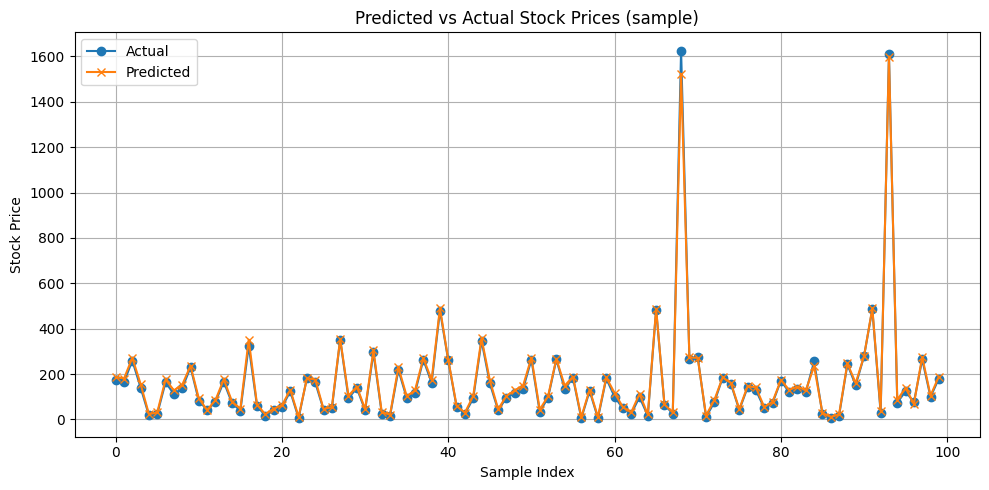

In [ ]:
best_model = StockRegressionModel.load_from_checkpoint(checkpoint_cb.best_model_path, input_dim=len(features_nn))

# Run evaluation
metrics = evaluate_model(best_model, datamodule=dm)

In [ ]:
def plot_regression_performance(metrics_path="lightning_logs", model_name="stock_model"):
    import os
    import pandas as pd
    import matplotlib.pyplot as plt

    log_dir = os.path.join(metrics_path, model_name)
    versions = [d for d in os.listdir(log_dir) if d.startswith("version_")]
    latest_version = max(versions, key=lambda x: int(x.split("_")[1]))
    metrics_file = os.path.join(log_dir, latest_version, 'metrics.csv')

    metrics_df = pd.read_csv(metrics_file)

    # Check if 'epoch' column exists, otherwise use 'step'
    if 'epoch' not in metrics_df.columns:
        if 'step' in metrics_df.columns:
            # Assume 'step' represents epochs if 'epoch' is missing
            metrics_df.rename(columns={'step': 'epoch'}, inplace=True)
        else:
            raise KeyError("Neither 'epoch' nor 'step' column found in metrics.csv")

    # Assuming 'epoch' is now present (either originally or renamed from 'step')
    metrics_df = metrics_df.groupby(['epoch'], sort=False).last().reset_index(drop=False) #changed to drop=False to keep epoch index
    metrics_df['epoch'] += 1  # for 1-indexed display

    # Rename for convenience
    metrics_df.rename(columns={
        'train_loss_epoch': 'train_loss',
        'val_loss': 'val_loss'
    }, inplace=True)

    fig, ax = plt.subplots(figsize=(8, 5))
    if 'train_loss' in metrics_df.columns:
        ax.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
    if 'val_loss' in metrics_df.columns:
        ax.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training and Validation Loss")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics_df


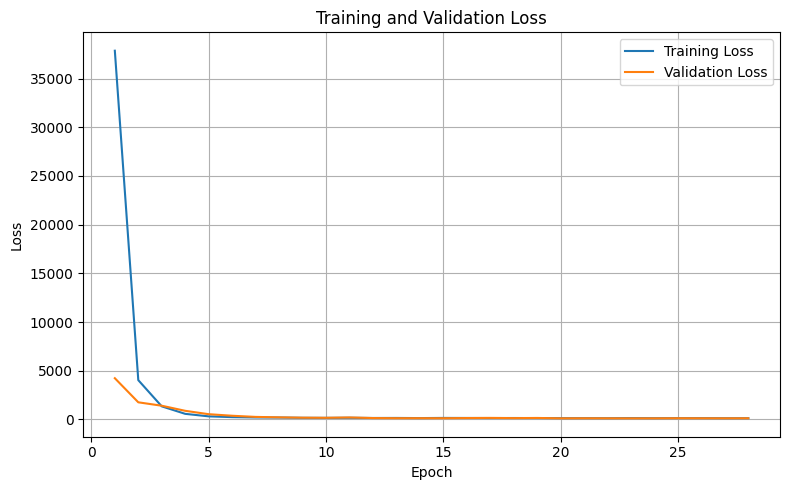

In [ ]:
metrics_df = plot_regression_performance("lightning_logs")

## Model evaluation

After selecting your final model, which could be a compromise of performance, interpretability and complexity, you should evaluate its performance on the test set.
You might have tuned your model using a certain metric, but now you should describe the model performance using all relevant metrics.
If you have some business insight, why a certain metric is relevant, you should explain it.
Construct a suitable baseline to benchmark your result and to put them in the context.
Discuss your results, do they seem good enough to be used in practice? If not, what should be improved. Discuss what type of errors is your model making.

In [ ]:
def evaluate_shap_feature_importance(estimator, X):
    print("Calculating SHAP values...")
    explainer = shap.TreeExplainer(estimator.named_steps['regressor'])
    feature_names = estimator.named_steps['preprocessor'].get_feature_names_out()
    X_processed = estimator.named_steps['preprocessor'].transform(X)
    shap_values = explainer.shap_values(X_processed)

    print("Plotting SHAP summary (bar)...")
    shap.summary_plot(shap_values, X_processed, feature_names=feature_names,plot_type="bar")

    print("Plotting SHAP summary (beeswarm)...")
    shap.summary_plot(shap_values, X_processed,feature_names=feature_names, plot_type="dot")



def evaluate_permutation_feature_importance(model, X, y, n_repeats=30, random_state=0):

    print("Calculating Permutation Importance...")
    perm_result =permutation_importance(model, X,y,n_repeats=n_repeats, random_state=random_state, n_jobs=-1)
    sorted_idx = perm_result.importances_mean.argsort()

    plt.figure(figsize=(10, 5))
    plt.barh(X.columns[sorted_idx],perm_result.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance with Permutation")
    plt.show()

In [73]:
def evaluate_model(model, X_test, y_test, benchmark_column='Close_Lag_1'):

    y_test_pred = model.predict(X_test)

    #model metrics
    mse_test =mean_squared_error(y_test, y_test_pred)
    mae_test =mean_absolute_error(y_test, y_test_pred)
    mape_test= mean_absolute_percentage_error(y_test, y_test_pred)
    R_2_test = r2_score(y_test, y_test_pred)
    adj_R2_test = 1- ((1-R_2_test)*(X_test.shape[0] - 1)/(X_test.shape[0]- X_test.shape[1] -1))

    #benchmark metrics
    y_pred_benchmark = X_test[benchmark_column]
    mse_benchmark = mean_squared_error(y_test, y_pred_benchmark)
    mae_benchmark = mean_absolute_error(y_test, y_pred_benchmark)
    mape_benchmark = mean_absolute_percentage_error(y_test, y_pred_benchmark)
    R_2_benchmark = r2_score(y_test, y_pred_benchmark)
    adj_R2_benchmark = 1 - ((1 -R_2_benchmark) *(X_test.shape[0] -1) /(X_test.shape[0]-X_test.shape[1] - 1))

    print("---- Model Evaluation ----")
    print("Mean Squared Error on test set:",mse_test)
    print("Root Mean Squared Error on test set:",np.sqrt(mse_test))
    print("Mean Absolute Error on test set:",mae_test)
    print("Mean Absolute Percentage Error on test set:",mape_test)
    print("R^2 on test set:", R_2_test)
    print("Adjusted R^2 on test set:", adj_R2_test)

    print("---- Benchmark Comparison ----")
    print('Benchmark:',benchmark_column)
    print("Mean Squared Error on benchmark:",mse_benchmark)
    print("Root Mean Squared Error on benchmark:",np.sqrt(mse_benchmark))
    print("Mean Absolute Error on benchmark:",mae_benchmark)
    print("Mean Absolute Percentage Error on benchmark:",mape_benchmark)
    print("R^2 on benchmark:", R_2_benchmark)
    print("Adjusted R^2 on benchmark:", adj_R2_benchmark)

In [74]:
evaluate_model(linear_pipe, X_test_lin, y_test)

---- Model Evaluation ----
Mean Squared Error on test set: 72.97369563286888
Root Mean Squared Error on test set: 8.542464259970238
Mean Absolute Error on test set: 3.51060908239742
Mean Absolute Percentage Error on test set: 0.03303049707951563
R^2 on test set: 0.9987833955201704
Adjusted R^2 on test set: 0.9987760876322006
---- Benchmark Comparison ----
Benchmark: Close_Lag_1
Mean Squared Error on benchmark: 72.6784363408748
Root Mean Squared Error on benchmark: 8.52516488643327
Mean Absolute Error on benchmark: 3.347884622698105
Mean Absolute Percentage Error on benchmark: 0.025471241962348054
R^2 on benchmark: 0.9987883180305933
Adjusted R^2 on benchmark: 0.9987810397111113


In [75]:
evaluate_model(ridge_search.best_estimator_, X_test_lin, y_test)

---- Model Evaluation ----
Mean Squared Error on test set: 74.1395978431241
Root Mean Squared Error on test set: 8.610435403806482
Mean Absolute Error on test set: 3.521279823556537
Mean Absolute Percentage Error on test set: 0.033080726886472275
R^2 on test set: 0.9987639578058031
Adjusted R^2 on test set: 0.9987565331595595
---- Benchmark Comparison ----
Benchmark: Close_Lag_1
Mean Squared Error on benchmark: 72.6784363408748
Root Mean Squared Error on benchmark: 8.52516488643327
Mean Absolute Error on benchmark: 3.347884622698105
Mean Absolute Percentage Error on benchmark: 0.025471241962348054
R^2 on benchmark: 0.9987883180305933
Adjusted R^2 on benchmark: 0.9987810397111113


In [76]:
evaluate_model(lasso_search.best_estimator_, X_test_lin, y_test)

---- Model Evaluation ----
Mean Squared Error on test set: 74.04490364606313
Root Mean Squared Error on test set: 8.604934842639027
Mean Absolute Error on test set: 3.511760894799854
Mean Absolute Percentage Error on test set: 0.03270963307128923
R^2 on test set: 0.9987655365306211
Adjusted R^2 on test set: 0.9987581213674465
---- Benchmark Comparison ----
Benchmark: Close_Lag_1
Mean Squared Error on benchmark: 72.6784363408748
Root Mean Squared Error on benchmark: 8.52516488643327
Mean Absolute Error on benchmark: 3.347884622698105
Mean Absolute Percentage Error on benchmark: 0.025471241962348054
R^2 on benchmark: 0.9987883180305933
Adjusted R^2 on benchmark: 0.9987810397111113


In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(knn_grid_search.best_estimator_.predict(X_test_knn), label='Predicted')
plt.title('KNN Predictions vs Actual Close Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
evaluate_permutation_feature_importance(knn_grid_search.best_estimator_, X_test_knn, y_test)

## Model interpretation

Use at least two different techniques for model interpretability. Discuss what are the most important features of your model, and how they impact the model performance. Pick a few examples of errors that your model is making, and check which features lead to thess errors.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Fold 1 ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4834.338


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 3823.063 >= min_delta = 0.0. New best score: 1011.274


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 86.973 >= min_delta = 0.0. New best score: 924.302


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 116.004 >= min_delta = 0.0. New best score: 808.298


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 251.952 >= min_delta = 0.0. New best score: 556.346


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 174.805 >= min_delta = 0.0. New best score: 381.541


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 99.854 >= min_delta = 0.0. New best score: 281.688


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 47.760 >= min_delta = 0.0. New best score: 233.928


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 61.495 >= min_delta = 0.0. New best score: 172.433


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 8.816 >= min_delta = 0.0. New best score: 163.617


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 31.125 >= min_delta = 0.0. New best score: 132.492


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.785 >= min_delta = 0.0. New best score: 129.708


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 8.054 >= min_delta = 0.0. New best score: 121.654


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 5.460 >= min_delta = 0.0. New best score: 116.194


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 116.107


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.709 >= min_delta = 0.0. New best score: 114.397


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 10.875 >= min_delta = 0.0. New best score: 103.522


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 103.522. Signaling Trainer to stop.


Test MSE:  113.2660
Test MAE:  6.4444
Test R²:   0.9971


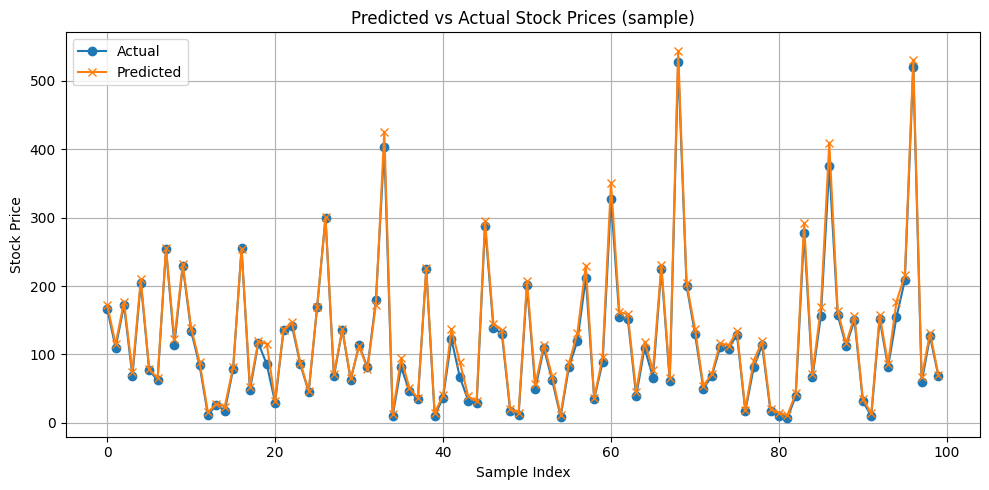

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Fold 2 ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4255.005


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2982.140 >= min_delta = 0.0. New best score: 1272.865


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 87.076 >= min_delta = 0.0. New best score: 1185.789


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 424.271 >= min_delta = 0.0. New best score: 761.518


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 247.799 >= min_delta = 0.0. New best score: 513.719


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 262.800 >= min_delta = 0.0. New best score: 250.919


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 84.747 >= min_delta = 0.0. New best score: 166.172


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 28.450 >= min_delta = 0.0. New best score: 137.722


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 13.422 >= min_delta = 0.0. New best score: 124.299


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 9.909 >= min_delta = 0.0. New best score: 114.390


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.019 >= min_delta = 0.0. New best score: 112.371


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 6.999 >= min_delta = 0.0. New best score: 105.372


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 4.157 >= min_delta = 0.0. New best score: 101.215


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 101.215. Signaling Trainer to stop.


Test MSE:  108.7817
Test MAE:  5.4636
Test R²:   0.9972


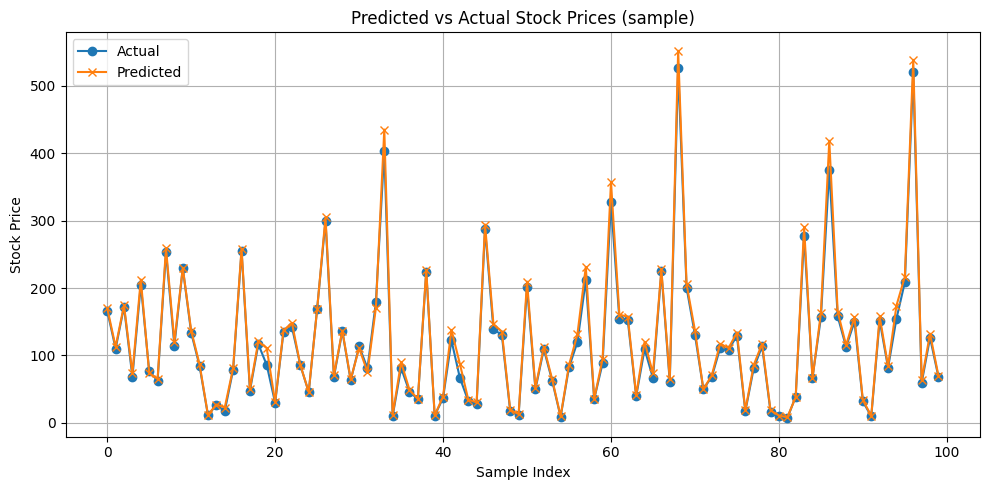

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Fold 3 ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4546.671


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 3391.360 >= min_delta = 0.0. New best score: 1155.310


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 151.503 >= min_delta = 0.0. New best score: 1003.808


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 281.270 >= min_delta = 0.0. New best score: 722.538


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 287.195 >= min_delta = 0.0. New best score: 435.343


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 151.097 >= min_delta = 0.0. New best score: 284.246


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 35.083 >= min_delta = 0.0. New best score: 249.164


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 56.585 >= min_delta = 0.0. New best score: 192.579


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 21.809 >= min_delta = 0.0. New best score: 170.770


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 8.594 >= min_delta = 0.0. New best score: 162.176


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 10.611 >= min_delta = 0.0. New best score: 151.565


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 12.838 >= min_delta = 0.0. New best score: 138.727


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.418 >= min_delta = 0.0. New best score: 137.309


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 6.410 >= min_delta = 0.0. New best score: 130.900


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.783 >= min_delta = 0.0. New best score: 129.117


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.036 >= min_delta = 0.0. New best score: 128.081


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 11.722 >= min_delta = 0.0. New best score: 116.359


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 4.746 >= min_delta = 0.0. New best score: 111.613


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 111.613. Signaling Trainer to stop.


Test MSE:  138.9642
Test MAE:  7.3881
Test R²:   0.9964


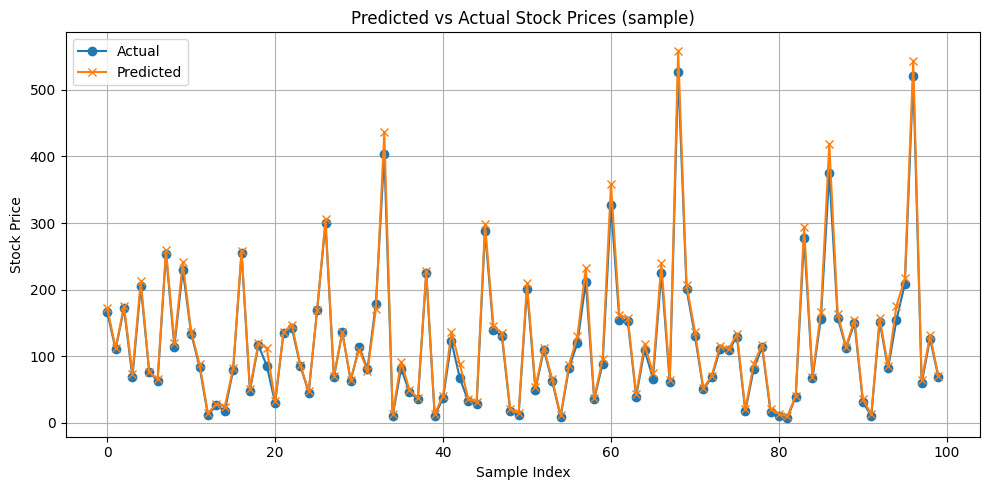

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Fold 4 ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 5410.023


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 4171.861 >= min_delta = 0.0. New best score: 1238.162


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 241.601 >= min_delta = 0.0. New best score: 996.561


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 335.439 >= min_delta = 0.0. New best score: 661.122


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 260.463 >= min_delta = 0.0. New best score: 400.659


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 161.299 >= min_delta = 0.0. New best score: 239.360


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 44.460 >= min_delta = 0.0. New best score: 194.900


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 17.260 >= min_delta = 0.0. New best score: 177.640


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 47.972 >= min_delta = 0.0. New best score: 129.668


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 3.967 >= min_delta = 0.0. New best score: 125.702


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 16.945 >= min_delta = 0.0. New best score: 108.757


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 8.861 >= min_delta = 0.0. New best score: 99.896


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.387 >= min_delta = 0.0. New best score: 99.509


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 4.308 >= min_delta = 0.0. New best score: 95.202


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.059 >= min_delta = 0.0. New best score: 94.142


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.702 >= min_delta = 0.0. New best score: 92.441


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.858 >= min_delta = 0.0. New best score: 90.583


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 90.583. Signaling Trainer to stop.


Test MSE:  123.7111
Test MAE:  4.9652
Test R²:   0.9968


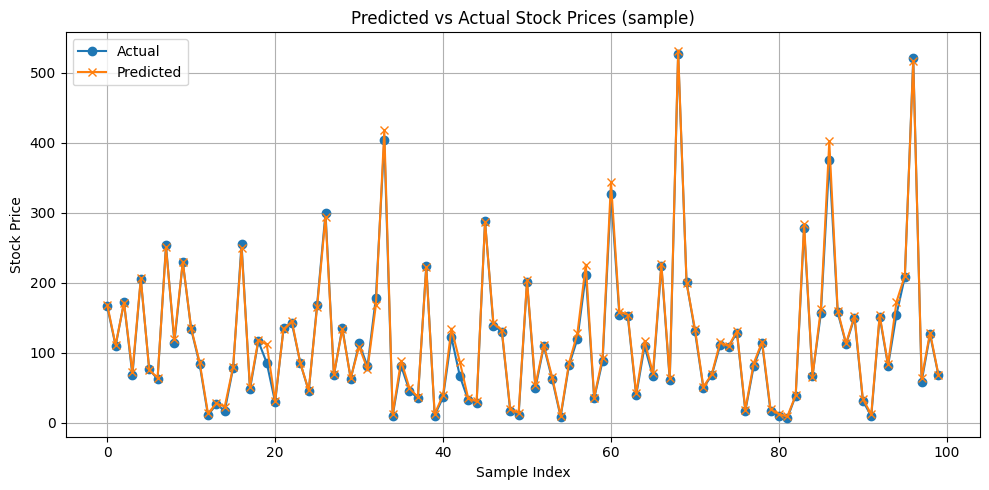

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Fold 5 ===


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 4677.393


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 3197.251 >= min_delta = 0.0. New best score: 1480.142


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 422.702 >= min_delta = 0.0. New best score: 1057.440


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 89.600 >= min_delta = 0.0. New best score: 967.840


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 382.290 >= min_delta = 0.0. New best score: 585.550


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 179.406 >= min_delta = 0.0. New best score: 406.144


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 146.151 >= min_delta = 0.0. New best score: 259.993


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 32.767 >= min_delta = 0.0. New best score: 227.226


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 15.568 >= min_delta = 0.0. New best score: 211.658


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 28.156 >= min_delta = 0.0. New best score: 183.501


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 11.920 >= min_delta = 0.0. New best score: 171.581


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 21.108 >= min_delta = 0.0. New best score: 150.473


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 5.082 >= min_delta = 0.0. New best score: 145.391


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 14.117 >= min_delta = 0.0. New best score: 131.274


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 6.711 >= min_delta = 0.0. New best score: 124.563


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 124.563. Signaling Trainer to stop.


Test MSE:  125.0950
Test MAE:  7.0784
Test R²:   0.9968


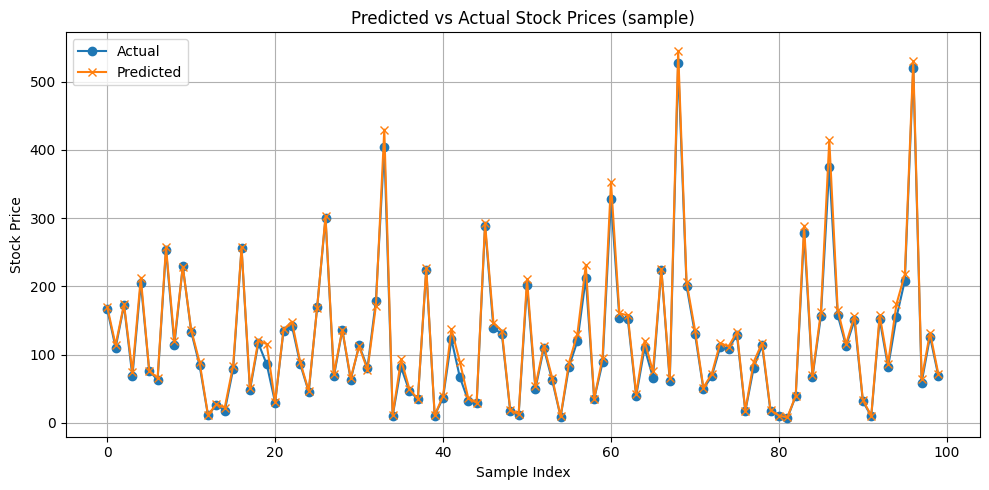


=== Cross-Validation Summary ===
MSE: 121.96 ± 10.50
MAE: 6.27 ± 0.93
R²:  0.9969 ± 0.0003


In [60]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

kf = cv
X = df_final[features_nn]
y = df_final[target_nn]

fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold + 1} ===")

    # DataModule for this fold
    dm_fold = StockDataModule(df_final, features_nn, target_nn, batch_size=64)
    dm_fold.setup(stage='fit', train_idx=train_idx, val_idx=val_idx)

    # New model
    model = StockRegressionModel(input_dim=len(features_nn))

    # Early stopping callback
    early_stop_cb = EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min",
        verbose=True
    )

    # Trainer
    trainer = pl.Trainer(
        max_epochs=50,
        callbacks=[early_stop_cb],
        logger=False,
        enable_checkpointing=False,
        enable_model_summary=False
    )

    # Train
    trainer.fit(model, datamodule=dm_fold)

    # Evaluate
    metrics = evaluate_model(model, datamodule=dm_fold)
    fold_metrics.append(metrics)

# Summarize
mse_list = [m['mse'] for m in fold_metrics]
mae_list = [m['mae'] for m in fold_metrics]
r2_list  = [m['r2']  for m in fold_metrics]

print("\n=== Cross-Validation Summary ===")
print(f"MSE: {np.mean(mse_list):.2f} ± {np.std(mse_list):.2f}")
print(f"MAE: {np.mean(mae_list):.2f} ± {np.std(mae_list):.2f}")
print(f"R²:  {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")
